# Keywords definition stage

In [94]:
target_keywords = ['apple', 'invest', 'divest', 'foreign']

# Web scraping stage

## Newsapi.org

In [3]:
%run scraper.py


Done


# Text analytics stage

## Imports

In [60]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None
from collections import Counter
import re
import numpy as np
from functools import reduce
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation

import nltk
nltk.download('punkt')
nltk.download('stopwords')

warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
import gensim.corpora as corpora
from gensim import matutils
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from tqdm import tqdm_notebook
tqdm_notebook().pandas()
from wordcloud import WordCloud

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

warnings.filterwarnings("ignore", category=DeprecationWarning, module='pyLDAvis')
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /home/kaushik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaushik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## UDFs

The two functions below are borrowed from a <a href="https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge"> Kaggle competition </a>.

They remove non ascii characters and standardize the text (can't -> cannot, i'm -> i am). This will make the tokenization process more efficient.

In [10]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

Integrate these two functions into a tokenizing function.

In [11]:
def tokenizer(text, stop_words):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

Group the tokens by category, apply a word count and display the top N most frequent tokens. 

In [12]:
def word_count(category, top_n=10):
    tokens = data[data['category'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(top_n)

In [13]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Now define some LDA functionalities.

In [14]:
# Define the LDA modeling function that takes the number of topics as a parameter
def LDA_model(num_topics, passes=1):
    return gensim.models.ldamodel.LdaModel(corpus=tqdm_notebook(corpus, leave=False),
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=1,
                                               eval_every=10,
                                               chunksize=2000,
                                               passes=passes,
                                               minimum_probability=0,
                                               per_word_topics=True)

# Define a metric to assess a good topic model: the coherence score
def compute_coherence(model):
    coherence = CoherenceModel(model=model, 
                           texts=df['tokens_bigram'].values,
                           dictionary=id2word, coherence='c_v')
    return coherence.get_coherence()

# Vary the number of topics in an interval and pick the number that optimizes the coherence score
def explore_models(topics_df, rg=range(5, 25)):
    id2word = corpora.Dictionary(topics_df['tokens_bigram'])
    texts = topics_df['tokens_bigram'].values
    corpus = [id2word.doc2bow(text) for text in texts]

    models = []
    coherences = []
    
    for num_topics in tqdm_notebook(rg, leave=False):
        lda_model = LDA_model(num_topics, passes=5)
        models.append(lda_model)
        coherence = compute_coherence(lda_model)
        coherences.append(coherence)
      
    plt.title('Choosing the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid(True)
    plt.plot(rg, coherences)
    
    return coherences, models

# Display topics and corresponding keywords
def display_topics(model, num_words=10):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=num_words)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    topics_df = pd.DataFrame(list(topics))
    topics_df.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    topics_df.columns = ['keyword_{0}'.format(i) for i in range(1, num_words+1)]
    return topics_df

# Build a document/topic matrix that will be uses for visualization, where a cell i,j contains the probabily of topic j in the document i
def get_document_topic_matrix(corpus, model):
    matrix = []
    doc_num = 0
    for row in tqdm_notebook(corpus):
        output = np.zeros(model.num_topics)
        topic_proba = model[row][0]
        print("Distribution of topics in document {} is {}\n".format(doc_num, topic_proba))
        for topic, proba in topic_proba:
            output[topic] = proba
        matrix.append(output)
        doc_num += 1
    matrix = np.array(matrix)
    return matrix

Keyword distribution in each document.

In [102]:
def find_top_keywords(matrix, topics_df, target_keywords, t=3, k=5):
    doc_keywords = []
    doc_keywords_filtered = []
    doc_num = 0
    
    for row in matrix:
        top_t = np.argsort(row)[::-1][:t]
        top_k = []
        for topic in top_t:
            top_k.extend(list(topics_df.iloc[topic, :k].values))
            top_k = list(set(top_k))

        doc_keywords.append(top_k)   
        doc_keywords_filtered.append([i for i in top_k if i in target_keywords])
        
        
        print("Top {} keywords in top {} topics for doc {} are: {}\n".format(k, t, doc_num, 
                                                                             doc_keywords))
        print("Matches among the top {} keywords in top {} topics for doc {} are: {}\n".format(
            k, t, doc_num, doc_keywords_filtered))
        
        doc_num += 1
        
    return doc_keywords, doc_keywords_filtered

## Load the data

In [15]:
data = pd.read_csv('./data/news.csv')
print(data.shape)
data.head(2)

(455, 9)


,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date
0,http://www.abc.net.au/news/caitlyn-gribbin/459...,A powerful new bloc in the Senate is forming —...,2018-06-05T14:02:38Z,abc-news-au,Conservatives' emerging Senate bloc could prov...,http://www.abc.net.au/news/2018-06-06/conserva...,http://www.abc.net.au/news/image/9216554-16x9-...,general,2018-06-05 22:21:43.065664
1,http://www.abc.net.au/news/david-lipson/7849048,A member of the Bali Nine dies in hospital in ...,2018-06-05T09:59:19Z,abc-news-au,Bali Nine member Tan Duc Thanh Nguyen dies in ...,http://www.abc.net.au/news/2018-06-05/bali-nin...,http://www.abc.net.au/news/image/9837864-16x9-...,general,2018-06-05 22:21:43.065664


## Explore

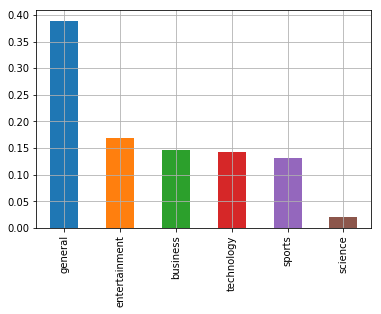

In [16]:
data.category.value_counts(normalize=True).plot(kind='bar', grid=True)
plt.show()

In [17]:
# Remove duplicate description columns
data = data.drop_duplicates('description')

# Remove rows with empty descriptions
data = data[~data['description'].isnull()]
print(data.shape)

(423, 9)


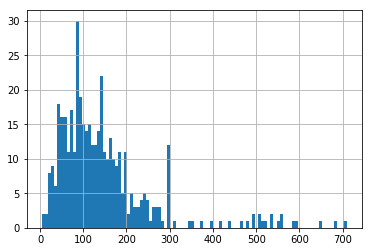

In [18]:
# Distribution of description lengths
data.description.map(len).hist(bins=100);

In [19]:
# Focus on the news articles with descriptions longer than 140 characters
# data = data[(data.description.map(len) > 140)]

data.reset_index(inplace=True, drop=True)
print(data.shape)

(423, 9)


In [20]:
# Sample some news due to memory constraints
data = data.sample(400, random_state=1)
data.reset_index(inplace=True, drop=True)
data.head(2)

,author,description,publishedAt,source,title,url,urlToImage,category,scraping_date
0,Sadie Gurman,The Trump administration has put its search fo...,2018-06-05T14:19:00Z,the-wall-street-journal,Trump Administration Sidelines Effort to Appoi...,https://www.wsj.com/articles/trump-administrat...,https://images.wsj.net/im-13139/social,business,2018-06-05 22:21:43.065664
1,talkSPORT,Arsenal are set to hold talks with Marouane Fe...,2018-06-04T15:03:00Z,talksport,Arsenal FC transfer news: Gunners set for talk...,http://talksport.com/football/arsenal-fc-trans...,https://talksport.com/sites/default/files/fiel...,sports,2018-06-05 22:21:43.065664


## Preprocess

In [21]:
data['description'] = data['description'].map(lambda d: str(d))

### Define stopwords

In [25]:
stop_words = []

f = open('./stopwords/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words

stop_words = list(set(stop_words + stopwords.words('english')))

print(len(stop_words))

705


### Tokenize

Build a tokenizer, which will, for every description, do the following:

- lowercase the text and clean it (separate function)
- break the descriptions into sentences and then break the sentences into tokens
- remove punctuation, stop words

We used to existing stopwords list that includes all stopwords in NLTK and more.

In [26]:
# Apply the tokenizer to each description through all rows
data['tokens'] = data['description'].progress_map(lambda d: tokenizer(d, stop_words))

# Let's check what the tokenization looks like for the first 3 descriptions
for descripition, tokens in zip(data['description'].head(3), data['tokens'].head(3)):
    print('description:', descripition)
    print('tokens:', tokens)
    print() 


description: The Trump administration has put its search for the Justice Department’s No. 3 official on the back burner after failing to persuade several early candidates to take the challenging position.
tokens: ['trump', 'administration', 'search', 'justice', 'department', 'official', 'burner', 'failing', 'persuade', 'early', 'candidates', 'challenging', 'position']

description: Arsenal are set to hold talks with Marouane Fellaini with his Manchester United contract expiring at the end of the month. Fellaini, the Belgium midfielder, is reportedly going to leave Old Trafford this summer when his deal runs out, having failed to agree new terms with Jose Mourinho’s side. AC Milan have emerged as contenders for the 30-year-old, who will feature for Belgium at this summer’s World Cup, while Paris Saint-Germain are also said to be interested in Fellaini.
tokens: ['arsenal', 'set', 'hold', 'talks', 'marouane', 'fellaini', 'manchester', 'united', 'contract', 'expiring', 'month', 'fellaini'

In [27]:
for category in set(data['category']):
    print('category :', category)
    print('top 10 keywords:', word_count(category, 10))
    print('---')

category : general
top 10 keywords: [('trump', 26), ('tuesday', 17), ('president', 17), ('york', 11), ('house', 9), ('government', 9), ('case', 8), ('designer', 8), ('city', 8), ('police', 8)]
---
category : science
top 10 keywords: [('earth', 2), ('longer', 2), ('computers', 2), ('spend', 2), ('time', 2), ('plasma', 2), ('moon', 1), ('making', 1), ('days', 1), ('track', 1)]
---
category : technology
top 10 keywords: [('apple', 10), ('based', 6), ('service', 6), ('today', 6), ('market', 6), ('company', 5), ('called', 5), ('microsoft', 5), ('hot', 4), ('data', 4)]
---
category : business
top 10 keywords: [('trump', 9), ('tuesday', 7), ('trade', 6), ('house', 6), ('prime', 5), ('president', 5), ('donald', 5), ('china', 4), ('time', 4), ('white', 4)]
---
category : entertainment
top 10 keywords: [('year', 5), ('game', 5), ('season', 4), ('destiny', 4), ('expansion', 4), ('london', 4), ('trap', 3), ('forsaken', 3), ('human', 3), ('led', 3)]
---
category : sports
top 10 keywords: [('cup', 1

Looking at these lists, can we formulate some hypotheses?

### TFIDF

In [28]:
# Create the TFIDF matrix, rows containing documents (descriptions) and columns containing unique terms (tokens) across the documents (descriptions), for unigram and bigram
vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words=stop_words)
vz = vectorizer.fit_transform(list(data['tokens'].map(lambda tokens: ' '.join(tokens))))

vz.shape

(400, 168)

In [29]:
# Create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

#### Remove words with low tfidf scores

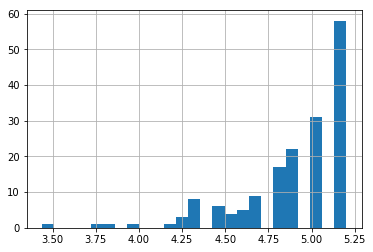

In [30]:
# Distribution of tfidf scores
tfidf.tfidf.hist(bins=25);

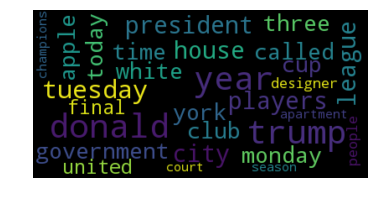

In [31]:
# Display the 30 tokens that have the lowest tfidf scores
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(30))

Not surprisingly, we end up with a list of very generic words (e.g., year, week, economic, sunday, monday etc.). These are very common across many descriptions. tfidf attributes a low score to them as a penalty for not being relevant.

We also notice that Trump, Donald, and president are part of this list for being mentioned in many articles.

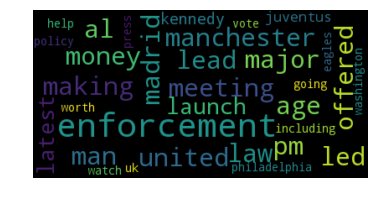

In [32]:
# Now display the 30 words with the highest tfidf scores
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(30))

In [33]:
# Add top 30 unimportant words (i.e., having lowest tfidf scores) to stopwords
unimportant_words = tfidf.sort_values(by=['tfidf'], ascending=True).head(30)
stop_words = list(set(stop_words + list(unimportant_words.index)))

In [34]:
# Remove these words from the data
data['tokens'] = data['description'].progress_map(lambda d: tokenizer(d, stop_words))
vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words=stop_words)
vz = vectorizer.fit_transform(list(data['tokens'].map(lambda tokens: ' '.join(tokens))))
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

We end up with less common words. These words naturally carry more meaning for the given description and may outline the underlying topic.

#### Visualize

In [35]:
# Use SVD to reduce dimensions to 50
svd = TruncatedSVD(n_components=50, random_state=1)
svd_tfidf = svd.fit_transform(vz)

svd_tfidf.shape

(400, 50)

In [36]:
# Now use t-SNE to reduce dimensions to 2
run = True

if run:
    # run this (takes times)    
    tsne_model = TSNE(n_components=2, verbose=1, random_state=1, n_iter=500)
    tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
    print(tsne_tfidf.shape)
    tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
    tsne_tfidf_df.columns = ['x', 'y']
    tsne_tfidf_df['category'] = data['category']
    tsne_tfidf_df['description'] = data['description']
    tsne_tfidf_df.to_csv('./data/tsne_tfidf.csv', encoding='utf-8', index=False)
else:
    # or import the dataset directly
    tsne_tfidf_df = pd.read_csv('./data/tsne_tfidf.csv')

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.578432
[t-SNE] Error after 175 iterations: 0.578432
(400, 2)


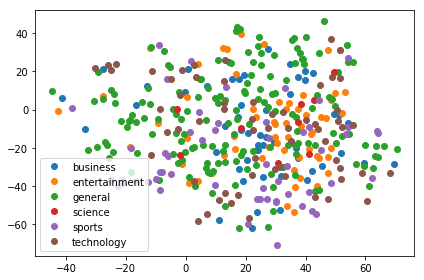

In [37]:
groups = tsne_tfidf_df.groupby('category')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend()
plt.tight_layout()
plt.show()

We're having two float numbers per discription. This is not interpretable at first sight. What we need to do is find a way to display these points on a plot and also attribute the corresponding description to each point.

In [40]:
output_notebook()
plot_tfidf = bp.figure(title="tf-idf clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category10'][len(tsne_tfidf_df['category'].unique())]
color_map = bmo.CategoricalColorMapper(factors=tsne_tfidf_df['category'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x='x', y='y', color={'field': 'category', 'transform': color_map}, 
                   legend='category', source=tsne_tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category":"@category"}

show(plot_tfidf)
plt.show()

Loading BokehJS ...

- We see a 2D projection of a high dimensional data. 
- Each dot is a document and the color encodes its category
- We can also hover on each data point to see the corresponding description and category

## Topic modeling

### LDA (Latent Dirichlet Allocation)

Kmeans separates the documents into disjoint clusters under the assumption that each cluster corresponds to a single topic. However, documents may in reality be characterized by a mixture of topics. This problem is dealt with by the LDA (Latent Dirichlet Allocation) algorithm.

LDA considers two things:

- Each document in a corpus is a weighted combination of several topics 
- Each topic has its collection of representative keywords

Ultimately, these are two probability distributions that the algorithm tries to approximate, starting from a random initialization until convergence:

1. For a given document, what is the distribution of topics that describe it?
2. For a given topic, what is the distribution of its words. Put differently, what is the importance of each word in defining the topic nature? 

The main hyperparameter that we have to set correctly in LDA models is the number of topics.

Given the number of topics, LDA starts shuffling the topic distribution in each document and the word distribution in each topic until the final results shows a high segregation of topics.

In [41]:
# Create a corpus and a dictionary using bigram tokens
df = data.copy()

bigram = gensim.models.Phrases(df['tokens'], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
df['tokens_bigram'] = df['tokens'].progress_map(lambda tokens: bigram_mod[tokens])

id2word = corpora.Dictionary(df['tokens_bigram'])
texts = df['tokens_bigram'].values
corpus = [id2word.doc2bow(text) for text in texts]

#### Find best number of topics

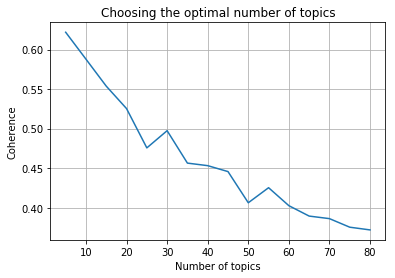

In [42]:
coherences, models = explore_models(df, rg=range(5, 85, 5))

35 seems to be a good number of topics.

#### Save into pickle

In [43]:
file_lda = open('./data/file_lda_coherences', 'wb')
pickle.dump(coherences, file_lda)
file_lda = open('./data/file_lda_models', 'wb')
pickle.dump(models, file_lda)

#### Load from pickle

In [44]:
file_lda = open('./data/file_lda_coherences', 'rb')
coherences = pickle.load(file_lda)
file_lda = open('./data/file_lda_models', 'rb')
models = pickle.load(file_lda)

#### Find best model

In [45]:
best_model = LDA_model(num_topics=35, passes=5)

#### Visualize

##### Artifact: Topic distribution within each document

In [46]:
matrix = get_document_topic_matrix(corpus, best_model)

Distribution of topics in document 0 is [(0, 0.0021978023), (1, 0.0021978023), (2, 0.0021978023), (3, 0.0021978023), (4, 0.0021978023), (5, 0.0021978023), (6, 0.0021978023), (7, 0.0021978023), (8, 0.0021978023), (9, 0.92527473), (10, 0.0021978023), (11, 0.0021978023), (12, 0.0021978023), (13, 0.0021978023), (14, 0.0021978023), (15, 0.0021978023), (16, 0.0021978023), (17, 0.0021978023), (18, 0.0021978023), (19, 0.0021978023), (20, 0.0021978023), (21, 0.0021978023), (22, 0.0021978023), (23, 0.0021978023), (24, 0.0021978023), (25, 0.0021978023), (26, 0.0021978023), (27, 0.0021978023), (28, 0.0021978023), (29, 0.0021978023), (30, 0.0021978023), (31, 0.0021978023), (32, 0.0021978023), (33, 0.0021978023), (34, 0.0021978023)]

Distribution of topics in document 1 is [(0, 0.00073260069), (1, 0.00073260069), (2, 0.97509158), (3, 0.00073260069), (4, 0.00073260069), (5, 0.00073260069), (6, 0.00073260069), (7, 0.00073260069), (8, 0.00073260069), (9, 0.00073260069), (10, 0.00073260069), (11, 0.0007

Distribution of topics in document 137 is [(0, 0.00073260051), (1, 0.00073260051), (2, 0.00073260051), (3, 0.00073260051), (4, 0.00073260051), (5, 0.00073260051), (6, 0.00073260051), (7, 0.00073260051), (8, 0.00073260051), (9, 0.00073260051), (10, 0.00073260051), (11, 0.00073260051), (12, 0.00073260051), (13, 0.00073260051), (14, 0.00073260051), (15, 0.00073260051), (16, 0.00073260051), (17, 0.00073260051), (18, 0.00073260051), (19, 0.00073260051), (20, 0.00073260051), (21, 0.00073260051), (22, 0.00073260051), (23, 0.00073260051), (24, 0.00073260051), (25, 0.00073260051), (26, 0.97509158), (27, 0.00073260051), (28, 0.00073260051), (29, 0.00073260051), (30, 0.00073260051), (31, 0.00073260051), (32, 0.00073260051), (33, 0.00073260051), (34, 0.00073260051)]

Distribution of topics in document 138 is [(0, 0.0010582013), (1, 0.0010582013), (2, 0.0010582013), (3, 0.0010582013), (4, 0.0010582013), (5, 0.0010582013), (6, 0.0010582013), (7, 0.0010582013), (8, 0.0010582013), (9, 0.0010582013), (

Distribution of topics in document 287 is [(0, 0.002380952), (1, 0.002380952), (2, 0.002380952), (3, 0.002380952), (4, 0.002380952), (5, 0.002380952), (6, 0.002380952), (7, 0.002380952), (8, 0.002380952), (9, 0.002380952), (10, 0.002380952), (11, 0.002380952), (12, 0.002380952), (13, 0.002380952), (14, 0.002380952), (15, 0.002380952), (16, 0.002380952), (17, 0.002380952), (18, 0.002380952), (19, 0.002380952), (20, 0.002380952), (21, 0.002380952), (22, 0.002380952), (23, 0.002380952), (24, 0.002380952), (25, 0.002380952), (26, 0.002380952), (27, 0.002380952), (28, 0.002380952), (29, 0.002380952), (30, 0.002380952), (31, 0.002380952), (32, 0.91904759), (33, 0.002380952), (34, 0.002380952)]

Distribution of topics in document 288 is [(0, 0.014285714), (1, 0.014285714), (2, 0.014285714), (3, 0.014285714), (4, 0.014285714), (5, 0.014285714), (6, 0.014285714), (7, 0.014285714), (8, 0.014285714), (9, 0.014285714), (10, 0.014285714), (11, 0.014285714), (12, 0.014285714), (13, 0.014285714), (14

Let's plot documents as clusters of topics, under the assumption that a document's topic is the one with the highest probability.

In [47]:
doc_topic = best_model.get_document_topics(corpus)
lda_keys = []
for i, desc in enumerate(data['description']):
    lda_keys.append(np.argmax(matrix[i, :]))

run = True
if run: 
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
    tsne_lda = tsne_model.fit_transform(matrix)
    lda_df = pd.DataFrame(tsne_lda, columns=['x', 'y'])
    lda_df['topic'] = lda_keys
    lda_df['topic'] = lda_df['topic'].map(str)
    lda_df['description'] = data['description']
    lda_df['category'] = data['category']
    lda_df.to_csv('./data/tsne_lda.csv', index=False, encoding='utf-8')
else:
    lda_df = pd.read_csv('./data/tsne_lda.csv')
    lda_df['topic'] = lda_df['topic'].map(str)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.601798
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.406447
[t-SNE] Error after 175 iterations: 0.406447


In [48]:
reset_output()
output_notebook()
plot_lda = bp.figure(title="KMeans clustering of the news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category20'][20] + d3['Category20b'][20] 
color_map = bmo.CategoricalColorMapper(factors=lda_df['topic'].unique(), palette=palette)

plot_lda.scatter('x', 'y', source=lda_df, 
                    color={'field': 'topic', 'transform': color_map}, 
                    legend='topic')
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "topic": "@topic", "category": "@category"}

show(plot_lda)
plt.show()

Loading BokehJS ...

##### Artifact: Top_n keywords for each topic and their distributions

In [75]:
topics_df = display_topics(best_model, 10)
topics_df

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,night,el,guatemala,continued,volcano,rodeo,dead,reported,palestinians,manafort
topic_1,fred,manchester,brazil,shakhtar,game,eagles,jose,mourinho,signing,reached
topic_2,fellaini,administration,ceo,trade,summer,belgium,feature,candidates,google,direct
topic_3,told,safety,federal,judge,light,block,deal,sky,sources,role
topic_4,produce,computers,creators,content,mps,pictured,june,influx,petition,parliament
topic_5,kneeling,politicising,grenell,subjective,best,roku,richard,review,office,launch
topic_6,super,eagles,anthem,bowl,karius,well,philadelphia,national,knee,champion
topic_7,week,korean,iconic,primary,california,weigh,advance,short,oliver,general
topic_8,liverpool,juventus,real,signing,madrid,body,led,scottsdale,officers,police
topic_9,trap,data,estiny,coming,cryptocurrency,crypto,attack,mining,serverless,police


In [59]:
panel = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
pyLDAvis.save_html(panel, './plots/pyLDAvis.html')

#### Artifact: Top_k keywords in top_t topics for each document

In [103]:
t = 3
k = 5

doc_keywords, doc_keywords_filtered = find_top_keywords(matrix, topics_df, target_keywords, t, k)

Top 5 keywords in top 3 topics for doc 0 are: [['sparks', 'trap', 'real', 'signing', 'coming', 'juventus', 'mueller', 'estiny', 'cryptocurrency', 'anxious', 'madrid', 'trade', 'liverpool', 'online', 'data']]

Matches among the top 5 keywords in top 3 topics for doc 0 are: [[]]

Top 5 keywords in top 3 topics for doc 1 are: [['sparks', 'trap', 'real', 'signing', 'coming', 'juventus', 'mueller', 'estiny', 'cryptocurrency', 'anxious', 'madrid', 'trade', 'liverpool', 'online', 'data'], ['sparks', 'real', 'signing', 'ceo', 'juventus', 'mueller', 'anxious', 'fellaini', 'madrid', 'trade', 'liverpool', 'online', 'administration', 'summer']]

Matches among the top 5 keywords in top 3 topics for doc 1 are: [[], []]

Top 5 keywords in top 3 topics for doc 2 are: [['sparks', 'trap', 'real', 'signing', 'coming', 'juventus', 'mueller', 'estiny', 'cryptocurrency', 'anxious', 'madrid', 'trade', 'liverpool', 'online', 'data'], ['sparks', 'real', 'signing', 'ceo', 'juventus', 'mueller', 'anxious', 'fell

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# References

- https://newsapi.org/
- http://pythonhosted.org/lda/
- <a href="http://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb#topic=3&lambda=0.87&term=">NLP post </a>
- <a href="https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/"> Topic Modeling python - sklearn</a>
- <a href="https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/"> Topic Modeling python - gensim</a>
- https://github.com/ahmedbesbes/How-to-mine-newsfeed-data-and-extract-interactive-insights-in-Python
- https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html